In [1]:
import os
import warnings
os.chdir('..')
warnings.filterwarnings('ignore')

# Firstly import the class of dataset
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('/repo/EEG-Image-Reconstruction/Generated/Data_Train/', task_type='geometric', n_jobs=10) # task type can be `geometric` or `random` or `all`

Loading .fif files:  38%|███▊      | 166/434 [00:05<00:04, 57.93it/s]

Loading .fif files: 100%|██████████| 434/434 [00:10<00:00, 42.07it/s]


In [2]:
import numpy as np
def get_sample(subj_id = None, get_pixel = False):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if subj_id == None:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
        if isinstance(subj_id, list):
            if metadata['subject_id'] in subj_id:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
        if isinstance(subj_id, int):
            if metadata['subject_id'] == subj_id:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
    if get_pixel:
        y = [t[get_pixel[0]*6 + get_pixel[1]] for t in y]
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_sample_choosen_trial(subj_id = None, choosen_trial = None):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if subj_id == None and metadata['trial_id'] in choosen_trial:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
        if isinstance(subj_id, list):
            if metadata['subject_id'] in subj_id and metadata['trial_id'] in choosen_trial:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
        if isinstance(subj_id, int):
            if metadata['subject_id'] == subj_id and metadata['trial_id'] in choosen_trial:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_sample_exclude(subj_id: int):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if metadata['subject_id'] != subj_id:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_target_pairs():
    targs = {}
    for i in range(len(EIR_Dataset)):
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if label in targs.keys():
            if not np.array_equal(targs[label], img): print('ахтунг')
        else:
            targs[label] = img
    return targs

In [3]:
import numpy as np
os.chdir('..')
loaded = np.load('/repo/EEG-Image-Reconstruction/Generated/Spectrums/exec_morlets1Hz_resolution16001.npz')

results_arr = []

i = 0
while f'psd_{i}' in loaded:
    
    psd = loaded[f'psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    label = int(loaded[f'label_{i}'])
    img = loaded[f'img_{i}']
    task_type = str(loaded[f'task_type_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age, label, img, task_type])
    i += 1

psd, s_id, t_id, gender, handiness, age, label, img, task_type = results_arr[0]


In [5]:
psd.shape

(63, 39, 16001)

In [49]:
print(task_type)

g


In [ ]:
X_wav = []
subj = []
trial = []
label_wav = []
tasks = []
for i in results_arr:
    if i[8] == 'g':
        X_wav.append(i[0])
        subj.append(i[1])
        trial.append(i[2])
        label_wav.append(i[6])
X_wav = np.array(X_wav)

In [ ]:
X_combined = X_wav.transpose(0, 2, 1, 3).reshape(434, 39*63, 16001)

In [ ]:
X_combined.shape

(434, 2457, 801)

: 

In [87]:
from pyriemann.estimation import XdawnCovariances
from sklearn.model_selection import train_test_split
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

n_components = 4  # pick some components

X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42, 
)

cov = XdawnCovariances(n_components)
print(X_train.shape)
data = cov.fit_transform(X_train, Y_train)
print(data.shape)
tg = TangentSpace()
data2 = tg.fit_transform(data, Y_train)
print(data2.shape)
clf = LogisticRegression(C=0.1, class_weight='balanced')
#clf.fit_predict(data2, Y_train)
cross_val_score(clf, data2, Y_train, cv=10, scoring='accuracy')


(176, 63, 16001)
(176, 104, 104)
(176, 5460)


array([0.44444444, 0.33333333, 0.55555556, 0.5       , 0.38888889,
       0.44444444, 0.23529412, 0.35294118, 0.29411765, 0.41176471])

In [90]:
cov = XdawnCovariances(n_components)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_combined, label_wav, test_size=0.4, stratify=label_wav, random_state=42, 
)
print(X_train.shape)
data = cov.fit_transform(X_train, Y_train)
print(data.shape)
tg = TangentSpace()
data2 = tg.fit_transform(data, Y_train)
print(data2.shape)

(260, 2457, 801)
(260, 104, 104)
(260, 5460)


Classification accuracy: 0.126437 


<Figure size 640x480 with 0 Axes>

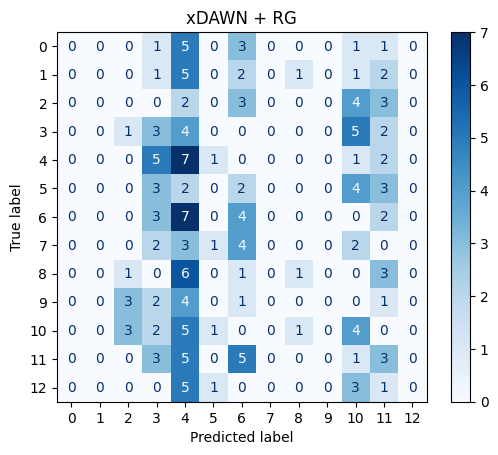

In [ ]:
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(),
                    LogisticRegression(C=0.1, class_weight='balanced'))

'''clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(),
                    MinMaxScaler(),
                    SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'))'''



preds_rg     = np.zeros(len(Y_test))

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train)
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test)
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
#names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''

plt.figure(1)
cm_rg = confusion_matrix(Y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title(f'xDAWN + RG')

plt.show()  # Display t

In [77]:
clf = LogisticRegression(C=0.1, class_weight='balanced')
#clf.fit_predict(data2, Y_train)
cross_val_score(clf, data2, Y_train, cv=10, scoring='accuracy')

array([1.        , 1.        , 1.        , 1.        , 0.96153846,
       1.        , 1.        , 0.88461538, 1.        , 0.96153846])

In [80]:
data2.shape

(260, 5460)

In [82]:
data.shape

(260, 104, 104)

In [26]:
import numpy as np
import pyriemann
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from scipy import signal
import pywt
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# 1. Генерация синтетических данных ЭЭГ (для примера)
def generate_eeg_data(n_samples=100, n_channels=10, n_times=256):
    """Генерация многоканального ЭЭГ-подобного сигнала"""
    rng = np.random.RandomState(42)
    noise = 0.1 * rng.randn(n_samples, n_channels, n_times)
    # Добавляем "события" - всплески активности в разных каналах
    for i in range(n_samples):
        event_channel = i % n_channels
        event_time = rng.randint(50, 200)
        noise[i, event_channel, event_time-10:event_time+10] += 0.5
    return noise

# Параметры данных
n_classes = 3  # Количество классов (слов/фонем)
n_subjects = 15 # Количество испытуемых
n_channels = 10 # Количество каналов ЭЭГ
n_times = 256   # Длина временного ряда (2 сек при 128 Гц)

# 2. Предобработка данных
def preprocess_eeg(eeg_data, sfreq=128):
    """Фильтрация и предобработка ЭЭГ"""
    # Полосовая фильтрация 8-30 Гц
    b, a = signal.butter(5, [8/(sfreq/2), 30/(sfreq/2)], btype='band')
    filtered_data = signal.filtfilt(b, a, eeg_data, axis=-1)
    
    # Удаление артефактов (упрощенный вариант)
    # На практике нужно использовать ICA или регрессию EOG
    clean_data = filtered_data - np.mean(filtered_data, axis=-1, keepdims=True)
    
    return clean_data

# 3. Извлечение признаков
def extract_features(eeg_data, method='covariance'):
    """Извлечение признаков из ЭЭГ"""
    if method == 'covariance':
        # Вычисление ковариационных матриц
        print(eeg_data.shape)
        cov_data = Covariances(estimator='lwf').transform(eeg_data)
        return cov_data
    elif method == 'wavelet+cov':
        # Вейвлет-преобразование + ковариация
        n_samples, n_channels, n_times = eeg_data.shape
        wavelet_features = []
        
        for sample in eeg_data:
            # Для каждого канала вычисляем вейвлет-коэффициенты
            channels_features = []
            for ch in range(n_channels):
                coeffs, _ = pywt.cwt(sample[ch], np.arange(8, 40), 'morl')
                print(np.array(coeffs).shape)
                # Сохраняем коэффициенты и добавляем индекс канала
                ch_feat = np.vstack([np.ones((1, coeffs.shape[1]))*ch, 
                                    sample[ch:ch+1], 
                                    coeffs])
                channels_features.append(ch_feat)
            
            # Объединяем все каналы
            sample_features = np.hstack(channels_features)
            wavelet_features.append(sample_features)

        print(np.array(wavelet_features).shape)
        
        # Вычисляем ковариационные матрицы
        cov_data = Covariances(estimator='lwf').transform(np.array(wavelet_features))
        return cov_data

# 4. Классификация с римановой геометрией
def riemannian_classification(X, y):
    """Классификация с использованием римановой геометрии"""
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Создание пайплайна: проекция в касательное пространство + классификатор
    pipeline = make_pipeline(
        TangentSpace(metric='riemann'),
        LinearDiscriminantAnalysis()
    )
    
    # Обучение и предсказание
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Оценка точности
    acc = accuracy_score(y_test, y_pred)
    return acc

# Основной процесс обработки
def main():
    # 1. Генерация синтетических данных
    print("Генерация данных...")
    X = []
    y = []
    for class_idx in range(n_classes):
        for _ in range(n_subjects):
            eeg_data = generate_eeg_data(n_samples=10, 
                                       n_channels=n_channels, 
                                       n_times=n_times)
            X.append(eeg_data)
            y.extend([class_idx] * 10)
    
    X = np.concatenate(X)
    y = np.array(y)
    
    # 2. Предобработка
    print("Предобработка...")
    X_processed = preprocess_eeg(X)
    
    # 3. Извлечение признаков (два метода)
    print("Извлечение признаков (ковариационные матрицы)...")
    cov_features = extract_features(np.array(X_processed), method='covariance')
    
    print("Извлечение признаков (вейвлет + ковариация)...")
    wavelet_cov_features = extract_features(np.array(X_processed), method='wavelet+cov')
    
    # 4. Классификация
    print("\nОценка точности:")
    print("Только ковариационные матрицы:")
    acc_cov = riemannian_classification(cov_features, y)
    print(f"Точность: {acc_cov:.2f}")
    
    print("\nВейвлет + ковариационные матрицы:")
    acc_wavelet = riemannian_classification(wavelet_cov_features, y)
    print(f"Точность: {acc_wavelet:.2f}")
    return cov_features, wavelet_cov_features

if __name__ == "__main__":
    a, b = main()

Генерация данных...
Предобработка...
Извлечение признаков (ковариационные матрицы)...
(450, 10, 256)


Извлечение признаков (вейвлет + ковариация)...
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32

KeyboardInterrupt: 

In [21]:
a.shape

(450, 10, 10)

In [22]:
b.shape

(450, 34, 34)